<pre><font size=6>Spoken Digit Recognition</font></pre>

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import librosa
import os



In [2]:
import os
import pathlib
import re
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import sklearn
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction =0.7
session = tf.compat.v1.Session(config=config)

In [3]:
#read the all file names in the recordings folder given by us
#(if you get entire path, it is very useful in future)
#save those files names as list in "all_files"
root=r"C:\Users\acer\Downloads\speech-recognition-assignment\recordings"
all_files=[os.path.join(root,i) for i in os.listdir(root)]


In [5]:

df_audio=pd.DataFrame()
label=[int(i[0]) for i in os.listdir(root)]
df_audio["path"]=all_files
df_audio["label"]=label

In [6]:
#info
df_audio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    2000 non-null   object
 1   label   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [8]:
from sklearn.utils import shuffle
df_audio = shuffle(df_audio, random_state=33)#don't change the random state

<pre><font size=4>Train and Validation split</font></pre>

In [9]:
#split the data into train and validation and save in X_train, X_test, y_train, y_test
#use stratify sampling
#use random state of 45
#use test size of 30%
from sklearn.model_selection import train_test_split
train_df,test_df=train_test_split(df_audio,test_size=0.3,stratify=df_audio["label"],random_state=45)
y_train=train_df["label"]
y_test=test_df["label"]
X_train=train_df.drop(columns=["label"])
X_test=test_df.drop(columns=["label"])

<pre><font size=4>Preprocessing</font>

All files are in the "WAV" format. We will read those raw data files using the librosa</pre>

In [11]:
sample_rate = 22050
def load_wav(x, get_duration=True):
    '''This return the array values of audio with sampling rate of 22050 and Duration'''
    #loading the wav file with sampling rate of 22050
    samples, sample_rate = librosa.load(x, sr=22050)
    if get_duration:
        duration = librosa.get_duration(samples, sample_rate)
        return [samples, duration]
    else:
        return samples

In [12]:
X_train.iloc[0]["path"]

'C:\\Users\\acer\\Downloads\\speech-recognition-assignment\\recordings\\6_yweweler_49.wav'

In [13]:
#use load_wav function that was written above to get every wave. 
#save it in X_train_processed and X_test_processed
# X_train_processed/X_test_processed should be dataframes with two columns(raw_data, duration) with same index of X_train/y_train
seq_tr=[]
dur_tr=[]
seq_te=[]
dur_te=[]
X_train_processed=pd.DataFrame()
X_test_processed=pd.DataFrame()
for i in X_train["path"].values:
    seq_tr.append(np.array(load_wav(i)[0]))
    dur_tr.append(load_wav(i)[1])
for i in X_test["path"].values:
    seq_te.append(np.array(load_wav(i)[0]))
    dur_te.append(load_wav(i)[1])
    
X_train_processed["raw_data"]=seq_tr
X_test_processed["raw_data"]=seq_te
X_train_processed["duration"]=dur_tr
X_test_processed["duration"]=dur_te
    
    
    

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

## Train Distribution

(array([601., 674., 107.,  15.,   2.,   0.,   0.,   0.,   0.,   1.]),
 array([0.16104308, 0.36453061, 0.56801814, 0.77150567, 0.9749932 ,
        1.17848073, 1.38196825, 1.58545578, 1.78894331, 1.99243084,
        2.19591837]),
 <BarContainer object of 10 artists>)

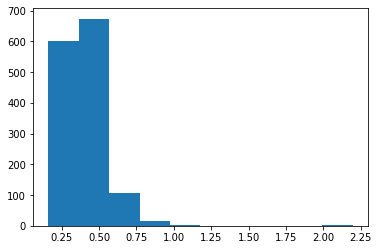

In [15]:
plt.hist(X_train_processed["duration"])

## Test Distribution

(array([601., 674., 107.,  15.,   2.,   0.,   0.,   0.,   0.,   1.]),
 array([0.16104308, 0.36453061, 0.56801814, 0.77150567, 0.9749932 ,
        1.17848073, 1.38196825, 1.58545578, 1.78894331, 1.99243084,
        2.19591837]),
 <BarContainer object of 10 artists>)

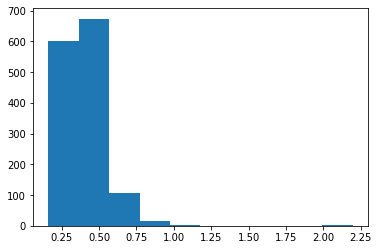

In [16]:
plt.hist(X_train_processed["duration"])

In [18]:
#print 0 to 100 percentile values with step size of 10 for train data duration. 

percentile = np.percentile(X_train_processed["duration"],[i for i in range(0,101,10)])
for i in range(len(percentile)):
    print(i*10,"th percentile is",percentile[i])

0 th percentile is 0.16104308390022676
10 th percentile is 0.25848072562358276
20 th percentile is 0.2974331065759637
30 th percentile is 0.3297777777777778
40 th percentile is 0.3569160997732426
50 th percentile is 0.38945578231292516
60 th percentile is 0.41328798185941046
70 th percentile is 0.4444671201814059
80 th percentile is 0.4826848072562358
90 th percentile is 0.5531655328798186
100 th percentile is 2.195918367346939


In [19]:
##print 90 to 100 percentile values with step size of 1. 
percentile = np.percentile(X_train_processed["duration"],[i for i in range(90,101,1)])
#print(percentile)
for i  in range(90,101,1):
    print(i,"th percentile is",percentile[i-90])

90 th percentile is 0.5531655328798186
91 th percentile is 0.5669832199546486
92 th percentile is 0.5790349206349206
93 th percentile is 0.599510657596372
94 th percentile is 0.611208163265306
95 th percentile is 0.6316009070294784
96 th percentile is 0.6431455782312925
97 th percentile is 0.6635741496598639
98 th percentile is 0.6957514739229022
99 th percentile is 0.79601179138322
100 th percentile is 2.195918367346939


<pre>Based on our analysis 99 percentile values are less than 0.8sec so we will limit maximum length of X_train_processed and X_test_processed to 0.8 sec. It is similar to pad_sequence for a text dataset. 

While loading the audio files, we are using sampling rate of 22050 so one sec will give array of length 22050. so, our maximum length is 0.8*22050 = 17640

Pad with Zero if length of sequence is less than 17640 else Truncate the number. 

Also create a masking vector for train and test. 

masking vector value = 1 if it is real value, 0 if it is pad value. Masking vector data type must be bool.
</pre>

In [21]:
max_length  = 17640

# Padding and Masking

In [22]:
max_length  = 17640
X_train_pad_seq=[]
X_test_pad_seq=[]
X_train_mask=[]
X_test_mask=[]

#Train data processing
for i in X_train_processed["raw_data"].values:
    if len(i)>17640:
        X_train_pad_seq.append(i[0:17640])
        X_train_mask.append(np.array([1]*max_length))
    elif len(i)<17640:
        k=len(i)
        i=np.pad(i,(0,17640-k))
        X_train_pad_seq.append(i)
        X_train_mask.append(np.concatenate((np.array([1]*k),np.array([0]*(17640-k)))))
        
 #Test Data processing       
for i in X_test_processed["raw_data"].values:
    if len(i)>17640:
        X_test_pad_seq.append(i[0:17640])
        X_test_mask.append(np.array([1]*max_length))
    elif len(i)<17640:
        k=len(i)
        i=np.pad(i,(0,17640-k))
        X_test_pad_seq.append(i)
        X_test_mask.append(np.concatenate((np.array([1]*k),np.array([0]*(17640-k)))))

X_train_pad_seq=np.array(X_train_pad_seq)
X_test_pad_seq=np.array(X_test_pad_seq)
X_train_mask=np.array(X_train_mask)
X_train_mask=X_train_mask.astype(bool)
X_test_mask=np.array(X_test_mask)
X_test_mask=X_test_mask.astype(bool)

In [23]:
## as discussed above, Pad with Zero if length of sequence is less than 17640 else Truncate the number. 
## save in the X_train_pad_seq, X_test_pad_seq
## also Create masking vector X_train_mask, X_test_mask

## all the X_train_pad_seq, X_test_pad_seq, X_train_mask, X_test_mask will be numpy arrays mask vector dtype must be bool.

In [24]:
X_test_mask.dtype    

dtype('bool')

### 1. Giving Raw data directly. 

# F1 Score Implementation Using Callbacks

In [26]:
#f1score implementations
class Score(tf.keras.callbacks.Callback):        
    def on_train_begin(self,logs={}):
        self.score={"train_f1score":[],"test_f1score":[],"val_acc":[]}
     
    def on_epoch_end(self,epoch,logs={}):
        pred_tr=np.argmax(self.model.predict([X_train_pad_seq,X_train_mask]),axis=1)
        pred_te=np.argmax(self.model.predict([X_test_pad_seq,X_test_mask]),axis=1)
        f1_sc_tr=sklearn.metrics.f1_score(pred_tr,y_train,average="micro")
        f1_sc_te=sklearn.metrics.f1_score(pred_te,y_test,average="micro")
        print("Train f1-score is",f1_sc_tr)
        print("Test f1-score is",f1_sc_te)
        self.score["train_f1score"].append(f1_sc_tr)
        self.score["test_f1score"].append(f1_sc_te)
sc=Score()

In [27]:
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Masking

# Model 1 (Raw Data)

In [28]:
inp=Input(shape=(17640,1),name="input-layer",dtype=float)
mask_inp=Input(shape=(17640,),name="input-mask",dtype=bool)
lstm=LSTM(units=100,name="lstm",activation="tanh")
model_lstm=lstm(inputs=inp,mask=mask_inp)
dense_layer=Dense(64,activation="tanh")(model_lstm)
drop=Dropout(0.5)(dense_layer)
bn=BatchNormalization()(drop)
dense_layer=Dense(50,activation="tanh")(bn)
output=Dense(10,activation="softmax")(dense_layer)
model_one=Model(inputs=[inp,mask_inp],outputs=[output])
model_one.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input-layer (InputLayer)        [(None, 17640, 1)]   0                                            
__________________________________________________________________________________________________
input-mask (InputLayer)         [(None, 17640)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 100)          40800       input-layer[0][0]                
                                                                 input-mask[0][0]                 
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           6464        lstm[0][0]                   

# Tensorboard callback

In [29]:
%load_ext tensorboard
#Learning rate scheduler
from tensorflow import keras
from tensorflow.keras.callbacks import LambdaCallback
def dynamic_learning_rate(epoch,lr):
    if (epoch+1)%2==0: 
        changed=lr*((1-0.10)**((epoch+1)//3)) # for every 3rd epoch decrasing learning rate by 10 percent
        return changed
    else:
        return lr #if not multiple of 3rd epoch return lr itself
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=5,write_graph=True,write_grads=True)
lr_scheduler=LearningRateScheduler(dynamic_learning_rate,verbose=1)
callbacks=[tensorboard_callback,sc] #sc->f1score

In [30]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

# 2. Running Model

In [36]:
#Model-1
model_one.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy,metrics=["accuracy"])
model_one.fit(x=[X_train_pad_seq,X_train_mask],y=y_train, batch_size=32,epochs=5,verbose=1,steps_per_epoch=1400//32,validation_data=([X_test_pad_seq,X_test_mask],y_test),callbacks=[tensorboard_callback,sc])

Epoch 1/5
43/43 [==============================] - 39s 848ms/step - loss: 2.3304 - accuracy: 0.1042 - val_loss: 2.3027 - val_accuracy: 0.1000
Train f1-score is 0.10000000000000002
Test f1-score is 0.10000000000000002
Epoch 2/5
43/43 [==============================] - 35s 828ms/step - loss: 2.3401 - accuracy: 0.0906 - val_loss: 2.3026 - val_accuracy: 0.0900
Train f1-score is 0.08928571428571429
Test f1-score is 0.09
Epoch 3/5
43/43 [==============================] - 36s 836ms/step - loss: 2.3316 - accuracy: 0.1025 - val_loss: 2.3028 - val_accuracy: 0.1000
Train f1-score is 0.10000000000000002
Test f1-score is 0.10000000000000002
Epoch 4/5
43/43 [==============================] - 36s 843ms/step - loss: 2.3238 - accuracy: 0.1029 - val_loss: 2.3027 - val_accuracy: 0.1000
Train f1-score is 0.10000000000000002
Test f1-score is 0.10000000000000002
Epoch 5/5
43/43 [==============================] - 37s 856ms/step - loss: 2.3246 - accuracy: 0.0939 - val_loss: 2.3028 - val_accuracy: 0.1017
Train

## Best validation f1-score for model-1 is obtained at epoch-5 ie 0.101

# Tensorboard graphs

In [30]:
%load_ext tensorboard
%tensorboard --logdir=logs/ --host localhost --port 8086

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 8086 (pid 12208), started 6:42:54 ago. (Use '!kill 12208' to kill it.)

### 2. Converting into spectrogram and giving spectrogram data as input  
<pre>
We can use librosa to convert raw data into spectrogram. A spectrogram shows the features in a two-dimensional representation with the
intensity of a frequency at a point in time i.e we are converting Time domain to frequency domain. you can read more about this in https://pnsn.org/spectrograms/what-is-a-spectrogram
</pre>

In [30]:
def convert_to_spectrogram(raw_data):
    '''converting to spectrogram'''
    spectrum = librosa.feature.melspectrogram(y=raw_data, sr=sample_rate, n_mels=64)
    logmel_spectrum = librosa.power_to_db(S=spectrum, ref=np.max)
    return logmel_spectrum

# Converting Raw Sequence to Spectogram Data

In [31]:
##use convert_to_spectrogram and convert every raw sequence in X_train_pad_seq and X_test_pad-seq.
## save those all in the X_train_spectrogram and X_test_spectrogram ( These two arrays must be numpy arrays)
##use convert_to_spectrogram and convert every raw sequence in X_train_pad_seq and X_test_pad-seq.
## save those all in the X_train_spectrogram and X_test_spectrogram ( These two arrays must be numpy arrays)
X_train_spectrogram=[]
X_test_spectrogram=[]

for i in X_train_pad_seq:
    X_train_spectrogram.append(convert_to_spectrogram(i))

for i in X_test_pad_seq:
    X_test_spectrogram.append(convert_to_spectrogram(i))
    
X_train_spectrogram=np.array(X_train_spectrogram)
X_test_spectrogram=np.array(X_test_spectrogram)



<font size=4>Grader function 6 </font>

In [32]:
def grader_spectrogram():
    flag_shape = (X_train_spectrogram.shape==(1400,64, 35)) and (X_test_spectrogram.shape == (600, 64, 35))
    return flag_shape
grader_spectrogram()

True

<pre>
Now we have

Train data: X_train_spectrogram and y_train  
Test data: X_test_spectrogram and y_test   

We will create a LSTM model which takes this input. 

Task:

1. Create an LSTM network which takes "X_train_spectrogram" as input and has to return output at every time step. 
2. Average the output of every time step and give this to the Dense layer of any size. 
(ex: Output from LSTM will be  (#., time_steps, features) average the output of every time step i.e, you should get (#.,time_steps) 
and then pass to dense layer )
3. give the above output to Dense layer of size 10( output layer) and train the network with sparse categorical cross entropy.  
4. Use tensorboard to plot the graphs of loss and metric(use micro F1 score as metric) and histograms of gradients. 
5. make sure that it won't overfit. 
6. You are free to include any regularization
</pre>

# F1 Score Implementation for Model-2

In [33]:
#f1score implementations
class Score2(tf.keras.callbacks.Callback):        
    def on_train_begin(self,logs={}):
        self.score={"train_f1score":[],"test_f1score":[],"val_acc":[]}
     
    def on_epoch_end(self,epoch,logs={}):
        pred_tr=np.argmax(self.model.predict(X_train_spectrogram),axis=1)
        pred_te=np.argmax(self.model.predict(X_test_spectrogram),axis=1)
        f1_sc_tr=sklearn.metrics.f1_score(pred_tr,y_train,average="micro")
        f1_sc_te=sklearn.metrics.f1_score(pred_te,y_test,average="micro")
        print("Train f1-score is",f1_sc_tr)
        print("Test f1-score is",f1_sc_te)
        self.score["train_f1score"].append(f1_sc_tr)
        self.score["test_f1score"].append(f1_sc_te)
sc2=Score2()

## https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D

## Model-2

In [34]:
inp=Input(shape=(64,35),name="input_layer")
lstm=LSTM(units=256,activation="tanh",return_sequences=True)(inp)
glob=tf.keras.layers.GlobalAveragePooling1D(data_format="channels_first")(lstm)
den=Dense(128,activation="relu",name="dense-layer1")(glob)
drop=Dropout(0.5)(den)
den=Dense(64,activation="relu",name="dense-layer2")(drop)
bn=BatchNormalization()(den)
den=Dense(32,activation=tf.keras.layers.LeakyReLU(),name="dense-layer3")(bn)
output=Dense(10,activation="softmax",name="output-layer")(den)
model_two=Model(inputs=inp,outputs=output)

In [35]:
model_two.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 64, 35)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64, 256)           299008    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense-layer1 (Dense)         (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense-layer2 (Dense)         (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256 

# Running Model-2

In [37]:
#Model
model_two.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy,metrics=["accuracy"])
model_two.fit(x=X_train_spectrogram,y=y_train,batch_size=32,epochs=20,verbose=1,steps_per_epoch=1400//32,validation_data=(X_test_spectrogram,y_test),callbacks=[tensorboard_callback,sc2])

Epoch 1/20
43/43 [==============================] - 4s 44ms/step - loss: 2.2702 - accuracy: 0.1480 - val_loss: 2.2689 - val_accuracy: 0.2083
Train f1-score is 0.21642857142857144
Test f1-score is 0.20833333333333334
Epoch 2/20
43/43 [==============================] - 1s 18ms/step - loss: 1.8086 - accuracy: 0.3224 - val_loss: 2.1816 - val_accuracy: 0.2767
Train f1-score is 0.27714285714285714
Test f1-score is 0.27666666666666667
Epoch 3/20
43/43 [==============================] - 1s 16ms/step - loss: 1.3793 - accuracy: 0.4959 - val_loss: 2.0578 - val_accuracy: 0.3517
Train f1-score is 0.35928571428571426
Test f1-score is 0.3516666666666667
Epoch 4/20
43/43 [==============================] - 1s 17ms/step - loss: 1.1344 - accuracy: 0.5815 - val_loss: 1.9379 - val_accuracy: 0.4983
Train f1-score is 0.4742857142857143
Test f1-score is 0.49833333333333335
Epoch 5/20
43/43 [==============================] - 1s 16ms/step - loss: 0.9436 - accuracy: 0.6465 - val_loss: 1.7980 - val_accuracy: 0.56

# Best Validation F1-score is at epoch 20 ie 0.87833333

# Tensorboard Visualisation for Model-2

In [58]:
%load_ext tensorboard
%tensorboard --logdir=logs/ --host localhost --port 8084

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 8084 (pid 18644), started 4:38:41 ago. (Use '!kill 18644' to kill it.)

### 3. data augmentation  
<pre>
Till now we have done with 2000 samples only. It is very less data. We are giving the process of generating augmented data below.

There are two types of augmentation:
1. time stretching - Time stretching either increases or decreases the length of the file. For time stretching we move the file 30% faster or slower
2. pitch shifting - pitch shifting moves the frequencies higher or lower. For pitch shifting we shift up or down one half-step.
</pre>

In [36]:
## generating augmented data. 
def generate_augmented_data(file_path):
    augmented_data = []
    samples = load_wav(file_path,get_duration=False)
    for time_value in [0.7, 1, 1.3]:
        for pitch_value in [-1, 0, 1]:
            time_stretch_data = librosa.effects.time_stretch(samples, rate=time_value)
            final_data = librosa.effects.pitch_shift(time_stretch_data, sr=sample_rate, n_steps=pitch_value)
            augmented_data.append(final_data)
    return augmented_data

In [37]:
temp_path = df_audio.iloc[0].path
aug_temp = generate_augmented_data(temp_path)

In [38]:
len(aug_temp)

9

As discussed above, for one data point, we will get 9 augmented data points.  

Split data into train and test (80-20 split)

We have 2000 data points(1600 train points, 400 test points) 

Do augmentation only on train data, after augmentation we will get 14400 train points. 

do the above steps i.e training with raw data and spectrogram data with augmentation.

In [39]:
from sklearn.model_selection import train_test_split
train_df,test_df=train_test_split(df_audio,test_size=0.2,stratify=df_audio["label"],random_state=30)
y_train=train_df["label"]
y_test=test_df["label"]
X_train=train_df.drop(columns=["label"])
X_test=test_df.drop(columns=["label"])

In [40]:
len(X_train)

1600

# Loading ALL Augumented Data To X_train_augumented list

In [41]:
X_train_augumented=[]
for i in X_train["path"].values:
    aug_file=generate_augmented_data(i)
    for j in range(9):
        X_train_augumented.append(aug_file[j])    

In [42]:
X_train_augumented=np.array(X_train_augumented)
print(X_train_augumented.shape)

(14400,)


C:\Users\acer\AppData\Local\Temp/ipykernel_8328/2018927794.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_train_augumented=np.array(X_train_augumented)


# Sequence Length

In [43]:
duration=[]
for i in X_train_augumented:
    duration.append(len(i))

(array([8.277e+03, 5.376e+03, 6.630e+02, 6.300e+01, 3.000e+00, 6.000e+00,
        6.000e+00, 0.000e+00, 0.000e+00, 6.000e+00]),
 array([ 2435. ,  9382.2, 16329.4, 23276.6, 30223.8, 37171. , 44118.2,
        51065.4, 58012.6, 64959.8, 71907. ]),
 <BarContainer object of 10 artists>)

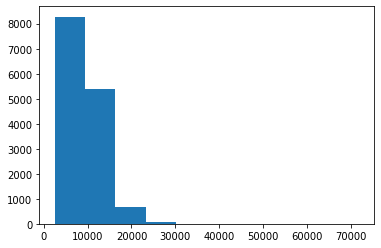

In [44]:
plt.hist(duration)

In [45]:
##print 90 to 100 percentile values with step size of 1. 
percentile = np.percentile(duration,[i for i in range(90,101,1)])
for i  in range(90,101,1):
    print(i,"th percentile is",percentile[i-90])

90 th percentile is 14518.1
91 th percentile is 14790.0
92 th percentile is 15089.96
93 th percentile is 15381.120000000024
94 th percentile is 15971.299999999997
95 th percentile is 16519.199999999997
96 th percentile is 17416.159999999996
97 th percentile is 18268.169999999955
98 th percentile is 19539.0
99 th percentile is 20958.400000000052
100 th percentile is 71907.0


# Selecting 98th percentile for max length and padding other values

In [46]:
#since taking 98th percentile ie 1954
max_length  = 19540

In [47]:
X_train_processed=pd.DataFrame()
X_train_processed["raw_data"]=X_train_augumented

In [48]:
#use load_wav function that was written above to get every wave. 
#save it in X_train_processed and X_test_processed
# X_train_processed/X_test_processed should be dataframes with two columns(raw_data, duration) with same index of X_train/y_train
seq_te=[]
X_test_processed=pd.DataFrame()
for i in X_test["path"].values:
    seq_te.append(np.array(load_wav(i)[0]))
    dur_te.append(load_wav(i)[1])
X_test_processed["raw_data"]=seq_te

# Masking and Padding

In [49]:
X_train_pad_seq=[]
X_test_pad_seq=[]
X_train_mask=[]
X_test_mask=[]

#Train data processing
for i in X_train_processed["raw_data"].values:
    if len(i)>max_length:
        X_train_pad_seq.append(i[0:max_length])
        X_train_mask.append(np.array([1]*max_length))
    elif len(i)<max_length:
        k=len(i)
        i=np.pad(i,(0,max_length-k))
        X_train_pad_seq.append(i)
        X_train_mask.append(np.concatenate((np.array([1]*k),np.array([0]*(max_length-k)))))
        
 #Test Data processing       
for i in X_test_processed["raw_data"].values:
    if len(i)>max_length:
        X_test_pad_seq.append(i[0:max_length])
        X_test_mask.append(np.array([1]*max_length))
    elif len(i)<max_length:
        k=len(i)
        i=np.pad(i,(0,max_length-k))
        X_test_pad_seq.append(i)
        X_test_mask.append(np.concatenate((np.array([1]*k),np.array([0]*(max_length-k)))))

X_train_pad_seq=np.array(X_train_pad_seq)
X_test_pad_seq=np.array(X_test_pad_seq)
X_train_mask=np.array(X_train_mask)
X_train_mask=X_train_mask.astype(bool)
X_test_mask=np.array(X_test_mask)
X_test_mask=X_test_mask.astype(bool)

In [50]:
X_train_pad_seq.shape

(14400, 19540)

# Repeating Labels since data is augumented

In [51]:
y_train=np.array(y_train)
y_train=np.repeat(y_train,9,axis=0)
y_test=np.array(y_test)

# Using Rawdata(Augumented data)


In [52]:
#Model-3
inp=Input(shape=(19540,1),name="input-layer",dtype=float)
mask_inp=Input(shape=(19540,),name="input-mask",dtype=bool)
lstm=LSTM(units=100,name="lstm",activation="tanh")
model_lstm=lstm(inputs=inp,mask=mask_inp)
dense_layer=Dense(64,activation="tanh")(model_lstm)
drop=Dropout(0.6)(dense_layer)
bn=BatchNormalization()(drop)
dense_layer=Dense(50,activation="tanh")(bn)
output=Dense(10,activation="softmax")(dense_layer)
model_three=Model(inputs=[inp,mask_inp],outputs=[output])
model_three.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input-layer (InputLayer)        [(None, 19540, 1)]   0                                            
__________________________________________________________________________________________________
input-mask (InputLayer)         [(None, 19540)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 100)          40800       input-layer[0][0]                
                                                                 input-mask[0][0]                 
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 64)           6464        lstm[0][0]                 

In [53]:
X_train_pad_seq.shape

(14400, 19540)

# Running Model-3

In [55]:
#Model-1
model_three.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy,metrics=["accuracy"])
model_three.fit(x=[X_train_pad_seq,X_train_mask],y=y_train, batch_size=32,epochs=10,verbose=1,steps_per_epoch=1400//32,validation_data=([X_test_pad_seq,X_test_mask],y_test),callbacks=[tensorboard_callback,sc])

Epoch 1/10
43/43 [==============================] - 35s 764ms/step - loss: 2.3320 - accuracy: 0.0798 - val_loss: 2.3040 - val_accuracy: 0.1000
Train f1-score is 0.10000000000000002
Test f1-score is 0.10000000000000002
Epoch 2/10
43/43 [==============================] - 32s 745ms/step - loss: 2.3340 - accuracy: 0.1079 - val_loss: 2.3036 - val_accuracy: 0.1000
Train f1-score is 0.10000000000000002
Test f1-score is 0.10000000000000002
Epoch 3/10
43/43 [==============================] - 32s 758ms/step - loss: 2.3261 - accuracy: 0.0996 - val_loss: 2.3033 - val_accuracy: 0.1000
Train f1-score is 0.10006944444444445
Test f1-score is 0.10000000000000002
Epoch 4/10
43/43 [==============================] - 34s 781ms/step - loss: 2.3054 - accuracy: 0.1189 - val_loss: 2.3039 - val_accuracy: 0.1000
Train f1-score is 0.10000000000000002
Test f1-score is 0.10000000000000002
Epoch 5/10
43/43 [==============================] - 32s 747ms/step - loss: 2.3144 - accuracy: 0.1032 - val_loss: 2.3038 - val_ac

# Best validation f1-score is at epoch 7 ie 0.1125

# Tensorboard for visualisation

In [59]:
%load_ext tensorboard
%tensorboard --logdir=logs/ --host localhost --port 8084

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 8084 (pid 18644), started 4:39:06 ago. (Use '!kill 18644' to kill it.)

# Converting raw augumented data to Spectogram data

In [56]:
X_train_spectrogram=[]
X_test_spectrogram=[]

for i in X_train_pad_seq:
    X_train_spectrogram.append(convert_to_spectrogram(i))

for i in X_test_pad_seq:
    X_test_spectrogram.append(convert_to_spectrogram(i))
    
X_train_spectrogram=np.array(X_train_spectrogram)
X_test_spectrogram=np.array(X_test_spectrogram)



In [61]:
X_test_spectrogram.shape

(400, 64, 39)

# Model-4

In [63]:
inp=Input(shape=(64,39),name="input_layer")
lstm=LSTM(units=256,activation="tanh",return_sequences=True)(inp)
glob=tf.keras.layers.GlobalAveragePooling1D(data_format="channels_first")(lstm)
den=Dense(128,activation="relu",name="dense-layer1")(glob)
drop=Dropout(0.5)(den)
den=Dense(64,activation="relu",name="dense-layer2")(drop)
bn=BatchNormalization()(den)
den=Dense(32,activation=tf.keras.layers.LeakyReLU(),name="dense-layer3")(bn)
output=Dense(10,activation="softmax",name="output-layer")(den)
model_four=Model(inputs=inp,outputs=output)

# Running Model-4

In [64]:
#Model
model_four.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy,metrics=["accuracy"])
model_four.fit(x=X_train_spectrogram,y=y_train,batch_size=32,epochs=20,verbose=1,steps_per_epoch=1400//32,validation_data=(X_test_spectrogram,y_test),callbacks=[tensorboard_callback,sc2])

Epoch 1/20
43/43 [==============================] - 2s 30ms/step - loss: 2.2817 - accuracy: 0.1617 - val_loss: 2.2948 - val_accuracy: 0.1000
Train f1-score is 0.10000000000000002
Test f1-score is 0.10000000000000002
Epoch 2/20
43/43 [==============================] - 1s 14ms/step - loss: 2.0697 - accuracy: 0.2749 - val_loss: 2.2276 - val_accuracy: 0.3375
Train f1-score is 0.33576388888888886
Test f1-score is 0.3375
Epoch 3/20
43/43 [==============================] - 1s 14ms/step - loss: 1.6688 - accuracy: 0.3872 - val_loss: 2.1560 - val_accuracy: 0.2225
Train f1-score is 0.20715277777777777
Test f1-score is 0.2225
Epoch 4/20
43/43 [==============================] - 1s 18ms/step - loss: 1.4158 - accuracy: 0.4777 - val_loss: 2.0787 - val_accuracy: 0.1725
Train f1-score is 0.15138888888888888
Test f1-score is 0.1725
Epoch 5/20
43/43 [==============================] - 1s 13ms/step - loss: 1.3454 - accuracy: 0.4965 - val_loss: 1.9925 - val_accuracy: 0.2575
Train f1-score is 0.21513888888888

# Best validation f1-score is at epoch 18 ie 0.825

# Tensorboard graph for visusalising

In [65]:
%load_ext tensorboard
%tensorboard --logdir=logs/ --host localhost --port 8084

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 8084 (pid 18644), started 4:43:51 ago. (Use '!kill 18644' to kill it.)

# END